### Imports

In [1]:
# General Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report

from utils import *

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
# We want to predict Claim Injury Type

In [3]:
# Neeed to create utils.py, model.py and a way to store/load the trained models.

# To-Do List: EDA, Preprocessing, and Data Preparation

**Our target is Claim Injury Type**

## 1. Exploratory Data Analysis (EDA)
   - **1.1 Data Overview**
     - Inspect the dataset structure.
     - Check for missing values (NAs) in each column. (There are missing values in the target, what's the % of NAs for each column)
     - Analyze basic statistics for numerical features (mean, median, min, max, etc.). ( .info and .describe)
     - Investigate categorical features (value counts, unique values).
     - Identify anomalies and duplicates in the data. (Age being NA is different from being 0 and Zip Code can be either a str or an int)

   - **1.2 Correlations and Relationships**
     - Compute correlation matrix for numerical features. (Can be done after dealing with categorical variables)
     - Identify and analyze feature relationships with target class using plots (e.g., boxplots, violin plots, histograms).

   - **1.3 Target Variable Analysis**
     - We should do it before and after preprocessing (maybe?).
     - Analyze class distribution of the target variable (severely unbalanced).
     - Identify potential patterns between features and classes with less data.
     - Discuss and visualize how imbalance could affect model performance.

## 2. Data Preprocessing
   - **2.1 Handling Missing Data and Anomalies**
     - Treat missing values (e.g., imputation, deletion). (We drop the ones that are in the target)
     - Convert variables that have contextual NAs into dummies (C-2 Date and C-3 Date could be NAs because at the time were yet to happen so they can become C-2 Ocurred, 0 or 1)

   - **2.2 Feature Engineering**
     - **2.2.1 Date Features**
       - Convert date features (e.g., `Accident Date`, `C-2 Date`) into meaningful time variables (e.g., days from a reference date).
       - For now we are calling the new feature related to date `feature` Days, we should decide a better name.
     - **2.2.2 Age**
       - Convert birth year into age in years.
       - We could group by Age and search for patterns.

   - **2.3 Categorical Feature Encoding**
     - **Nominal Features**
       - Apply Frequency Encoding (or Target Encoding, IDK if it is possible) for categorical features with many unique values (e.g., `Carrier Name`).
       - (We don't use Label Encoding for these features because it would imply a rank between them)
       - (One-Hot-Encoder creates a column for each class, so the dataset becomes a mess)
     - **Ordinal Features**
       - Apply Label Encoding for features with natural order (e.g., `Claim Injury Type`).
       - Ensure correct ordering during the encoding process. (Need to check this)
     - **Store Original Values**
       - Store encodings and the original values for potential reverse-mapping in future analysis. (Needed for submission)

   - **2.4 Feature Scaling**
     - Scale Data. (numerical features only)
     - Scale train and validation/test datasets separately to avoid data leakage.

## For now we don't need to worry with the steps below.

## 3. Dealing with Imbalanced Data (GPT suggested this)
   - **3.1 Resampling Techniques**
     - **Oversampling**: Try SMOTE or ADASYN to oversample minority classes.
     - **Undersampling**: Consider random undersampling of the majority class.
   - **3.2 Anomaly Detection**
     - Consider integrating anomaly detection methods like Isolation Forest for rare events or minority classes.
   - **3.3 Class Weights**
     - Modify class weights in models to give more importance to underrepresented classes.

## 4. Data Splitting
   - **4.1 Train-Validation Split**
     - Ensure proper splitting of data into train and validation.
     - Use stratified splitting to preserve the class distribution across datasets.
     - Use K-fold (and other splitting methods to deal with unbalanced dataset).

## 5. Baseline Model Training
   - **5.1 Baseline Models**
       - Create lists with different feature and parameters.
       - Select Baseline Models (e.g., Decision Tree, Logistic Regression, RandomForest)
       - Train models iterating through the lists.
   - **5.2 Gridsearch**
       - After having 1 or 2 models that outperform the other we try to optimise their preformace
       - Very time consuming and resource intensive

## 6. Predict Test
   - **6.1 Prepare Test**
       - Load Test.
       - Preprocess and Scale.
       - Load final model (saved in a file) and predict target
       - Decoded Target (from 0-8 to text)
       - Load submission sample and add predicted values
       - Profit
    
## 7. Train a NN
   - **7.1 How to NN**
       - Neural Networks are something that we will learn little in ML, in the 2º semester we will have Deep Learning that focus in NNs.
       - We shouldn't make direct comparisons to the other models
       - It can be a little hit or miss and not everyone can run them


### EDA will consiste of:
    - In-depth exploration of the dataset.
    - Feature creation, in order to better explain the information
    - Find trends, patterns or anomalities.


In [4]:
# For this study we will consider all dates in reference to 25 of Dec of 2023
reference_date = pd.to_datetime("2023-12-25")

### Import Train dataset and view

In [5]:
test_df = pd.read_csv("./data/test_data.csv")

In [6]:
train_df = pd.read_csv("./data/train_data.csv", dtype={ 29 : str})

In [7]:
train_df.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0


In [8]:
for col in train_df.columns:
    if col not in test_df.columns:
        print(col +" not in test")

Claim Injury Type not in test
Agreement Reached not in test
WCB Decision not in test


In [9]:
#train_df = train_df.drop(["Agreement Reached", "WCB Decision"],axis=1)

In [10]:
train_df["Claim Injury Type"].unique()

array(['2. NON-COMP', '4. TEMPORARY', nan, '3. MED ONLY',
       '5. PPD SCH LOSS', '6. PPD NSL', '1. CANCELLED', '8. DEATH',
       '7. PTD'], dtype=object)

In [11]:
train_df["Claim Injury Type"].value_counts()

Claim Injury Type
2. NON-COMP        291078
4. TEMPORARY       148507
3. MED ONLY         68906
5. PPD SCH LOSS     48280
1. CANCELLED        12477
6. PPD NSL           4211
8. DEATH              470
7. PTD                 97
Name: count, dtype: int64

The dataset is very unbalanced: </br>
    - PPD NSL, DEATH and PTD combined got less than 5k

In [12]:
train_df.info()

# ""First Hearing Date" has only 83,932 non-null entries, leaving most of the rows missing.
# "IME-4 Count" has only 71,843 non-null values, indicating a significant portion of missing data.
# "C-3 Date" has fewer entries (102,971), compared to "C-2 Date" (285,444), suggesting sparse data in the "C-3 Date" field.
# "OIICS Nature of Injury Description" is completely empty, with 0 non-null values

# 11 columns contain strings (text) or other types that are represented as objects, including date columns (e.g., "Accident Date," "Assembly Date") and categorical fields (e.g., "Carrier Name," "Gender").


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

In [13]:
train_df.describe().T

# outliers or data entry errors, especially for "Average Weekly Wage" and "Birth Year."
# variables contain zeros, age at injury, average weekly wage, birth_year, WCIO Part of the Body Code, Agreement Reached, Number of Dependents

# Age at Injury: Mean 42, range 0–117, most 31–54.
# Average Weekly Wage: Mean 504.6, max 2.6M, median 0.
# Birth Year: Mean 1877 (errors), most 1964–1988.
# Claim Identifier: Range 5.4M–1B.
# IME-4 Count: Mean 3.46, max 48.
# Industry Code: Range 11–92, most 45–62.
# WCIO Codes: Mid-range, Part of Body min -9 (error).
# Agreement Reached: Mean 0.06.
# Number of Dependents: Mean 3, max 6.


,count,mean,std,min,25%,50%,75%,max
Age at Injury,574026.0,4.211427e+01,1.425643e+01,0.0,31.0,42.0,54.0,117.0
Average Weekly Wage,545375.0,4.910883e+02,6.092918e+03,0.0,0.0,0.0,841.0,2828079.0
Birth Year,544948.0,1.886768e+03,4.146444e+02,0.0,1965.0,1977.0,1989.0,2018.0
Claim Identifier,593471.0,2.366760e+07,1.079271e+08,5393066.0,5593414.5,5791212.0,5991000.5,999891667.0
IME-4 Count,132803.0,3.207337e+00,2.832303e+00,1.0,1.0,2.0,4.0,73.0
Industry Code,564068.0,5.864531e+01,1.964417e+01,11.0,45.0,61.0,71.0,92.0
OIICS Nature of Injury Description,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WCIO Cause of Injury Code,558386.0,5.438114e+01,2.587428e+01,1.0,31.0,56.0,75.0,99.0
WCIO Nature of Injury Code,558369.0,4.101384e+01,2.220752e+01,1.0,16.0,49.0,52.0,91.0
WCIO Part Of Body Code,556944.0,3.973815e+01,2.236594e+01,-9.0,33.0,38.0,53.0,99.0


In [14]:
train_df["WCB Decision"].unique()
# Very weird, we cannot assume that nan are Work Related cases as the decision is unknown at the start of claim

array(['Not Work Related', nan], dtype=object)

In [15]:
# Age at Injury:
# Most common ages: 30, 31, 55.
# 98 unique values, with 3.44% missing data.

# Average Weekly Wage:
# 59.55% of entries have a value of 0, indicating many missing or invalid data points.
# Highly unique (75,878 values), with 8.30% missing data.

# Birth Year:
# 5.06% of entries have a value of 0 (likely errors).
# Reasonable spread for other years, but 8.32% missing data.

# Claim Identifier:
# Unique across all records, no missing data.

# IME-4 Count:
# 28.85% of entries show 1 exam, but 76.37% of data is missing.

# Industry Code:
# Top industries: 62 (22.36%), 92 (16.90%), 44 (7.81%).
# 5.28% missing data.

# OIICS Nature of Injury:
# All data is missing (100%).

# WCIO Codes (Cause, Nature, Part of Body):

# Common codes for injury cause, nature, and body part are well-distributed.
# ~6% missing data for each category.

# Agreement Reached:
# 93.93% of cases did not reach an agreement, with 6.07% where agreements were reached.
# 3.45% missing data.

# Number of Dependents:
# Most common values are 6, 1, and 3.
# 3.45% missing data.

def analyze_categorical_features_enhanced(data):
    """
    Enhanced analysis of categorical features with additional metrics and better formatting
    """
    categorical_columns = [
        'Age at Injury',
        'Average Weekly Wage',
        'Birth Year',
        'Claim Identifier',
        'IME-4 Count',
        'Industry Code',
        'OIICS Nature of Injury Description',
        'WCIO Cause of Injury Code',
        'WCIO Nature of Injury Code',
        'WCIO Part Of Body Code',
        'Agreement Reached',
        'Number of Dependents'
    ]

    analysis_results = {}

    for column in categorical_columns:
        print(f"\n{'='*70}")
        print(f"DETAILED ANALYSIS FOR: {column}")
        print('='*70)

        # Value counts with percentages
        value_counts = data[column].value_counts()
        value_percentages = data[column].value_counts(normalize=True) * 100

        print("\nTop 10 Values Distribution:")
        print("-"*50)
        for val, count in value_counts.head(3).items():
            percentage = value_percentages[val]
            print(f"{val}: {count:,} occurrences ({percentage:.2f}%)")

        # Unique values analysis
        unique_count = data[column].nunique()
        total_count = len(data)
        uniqueness_ratio = (unique_count / total_count) * 100
        print(f"\nUniqueness Analysis:")
        print("-"*50)
        print(f"Unique values: {unique_count:,}")
        print(f"Uniqueness ratio: {uniqueness_ratio:.2f}% of total records")

        # Numeric statistics if applicable
        if pd.api.types.is_numeric_dtype(data[column]):
            print("\nNumerical Statistics:")
            print("-"*50)
            stats = data[column].describe()


        # Missing values analysis
        missing_count = data[column].isnull().sum()
        missing_percentage = (missing_count / len(data)) * 100
        print(f"\nMissing Values Analysis:")
        print("-"*50)
        print(f"Missing count: {missing_count:,}")
        print(f"Missing percentage: {missing_percentage:.2f}%")

        # Additional cardinality metrics
        if not pd.api.types.is_numeric_dtype(data[column]):
            print("\nCardinality Analysis:")
            print("-"*50)
            rare_values = value_counts[value_counts == 1].count()
            print(f"Number of values appearing only once: {rare_values:,}")
            print(f"Percentage of rare values: {(rare_values/unique_count)*100:.2f}%")

        # Store results
        analysis_results[column] = {
            'unique_count': unique_count,
            'missing_count': missing_count,
            'missing_percentage': missing_percentage,
            'value_counts': value_counts,
            'uniqueness_ratio': uniqueness_ratio
        }

    return analysis_results

# Run the enhanced analysis
enhanced_analysis = analyze_categorical_features_enhanced(train_df)


DETAILED ANALYSIS FOR: Age at Injury

Top 10 Values Distribution:
--------------------------------------------------
31.0: 14,041 occurrences (2.45%)
30.0: 14,022 occurrences (2.44%)
32.0: 13,994 occurrences (2.44%)

Uniqueness Analysis:
--------------------------------------------------
Unique values: 108
Uniqueness ratio: 0.02% of total records

Numerical Statistics:
--------------------------------------------------

Missing Values Analysis:
--------------------------------------------------
Missing count: 19,445
Missing percentage: 3.28%

DETAILED ANALYSIS FOR: Average Weekly Wage

Top 10 Values Distribution:
--------------------------------------------------
0.0: 335,450 occurrences (61.51%)
250.0: 3,193 occurrences (0.59%)
600.0: 2,319 occurrences (0.43%)

Uniqueness Analysis:
--------------------------------------------------
Unique values: 120,024
Uniqueness ratio: 20.22% of total records

Numerical Statistics:
--------------------------------------------------

Missing Values

### Missing value, Dups and Feature encoding

#### See if there are missing values on the target

In [16]:
nan_count = train_df["Claim Injury Type"].isna().sum()
print(f"We found that {nan_count/train_df.shape[0] * 100}% of the training data has NAs on the target, therefor we will drop it.")
#nan_rows.value_counts
train_df = train_df.dropna(subset=["Claim Injury Type"])

We found that 3.276486972404717% of the training data has NAs on the target, therefor we will drop it.


#### See if there are duplicates on the dataset

In [17]:
dup_rows = train_df.duplicated()
dup_rows.value_counts()

False    574026
Name: count, dtype: int64

In [18]:
train_df.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'Claim Injury Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'Industry Code Description',
       'Medical Fee Region', 'OIICS Nature of Injury Description',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents'],
      dtype='object')

Change Zip Code to be only str as by deafual its both

In [19]:
train_df['Zip Length'] = train_df['Zip Code'].str.len()

In [20]:
# Attorney/Representative: strong correlation with Claim Injury Type (0.74), Carrier Type (0.46), Claim Identifier (0.49).
# Carrier Type: strong correlation with Claim Identifier (0.69), Claim Injury Type (0.54), COVID-19 Indicator (0.64).
# Claim Identifier: strong correlation with Claim Injury Type (0.62), Carrier Type (0.69), COVID-19 Indicator (0.75).
# Claim Injury Type: strong correlation with Attorney/Representative (0.74), Carrier Type (0.54), Claim Identifier (0.62), COVID-19 Indicator (0.55).
# COVID-19 Indicator: strong correlation with Carrier Type (0.64), Claim Identifier (0.75), Claim Injury Type (0.55).


# Select only numeric columns
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns

# Create correlation matrix rounded to 2 decimals
corr_matrix = train_df[numeric_cols].corr().round(2)

# Display the matrix
corr_matrix

# # Create heatmap with better formatting
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr_matrix,
#             annot=True,           # Show numbers
#             cmap='coolwarm',      # Color scheme
#             center=0,             # Center the colormap at 0
#             fmt='.2f',           # Show 2 decimal places
#             square=True)          # Make cells square

# plt.title('Correlation Matrix Heatmap')
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
# plt.yticks(rotation=0)
# plt.tight_layout()                   # Adjust layout to prevent label cutoff
# plt.show()



,Age at Injury,Average Weekly Wage,Birth Year,Claim Identifier,IME-4 Count,Industry Code,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents,Zip Length
Age at Injury,1.00,0.02,0.01,-0.01,0.07,0.00,NaN,-0.03,0.02,0.01,0.02,0.0,0.00
Average Weekly Wage,0.02,1.00,0.00,-0.00,-0.01,0.01,NaN,0.00,0.01,-0.00,0.01,-0.0,-0.00
Birth Year,0.01,0.00,1.00,0.03,-0.00,0.02,NaN,-0.00,-0.01,-0.01,-0.03,-0.0,0.02
Claim Identifier,-0.01,-0.00,0.03,1.00,-0.11,-0.01,NaN,-0.03,-0.04,-0.23,-0.08,0.0,-0.00
IME-4 Count,0.07,-0.01,-0.00,-0.11,1.00,-0.20,NaN,-0.06,0.03,0.07,0.09,0.0,0.00
Industry Code,0.00,0.01,0.02,-0.01,-0.20,1.00,NaN,0.05,-0.00,-0.04,-0.08,-0.0,-0.00
OIICS Nature of Injury Description,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WCIO Cause of Injury Code,-0.03,0.00,-0.00,-0.03,-0.06,0.05,NaN,1.00,0.17,0.03,-0.00,0.0,-0.00
WCIO Nature of Injury Code,0.02,0.01,-0.01,-0.04,0.03,-0.00,NaN,0.17,1.00,0.23,0.03,-0.0,-0.00
WCIO Part Of Body Code,0.01,-0.00,-0.01,-0.23,0.07,-0.04,NaN,0.03,0.23,1.00,0.02,0.0,-0.00


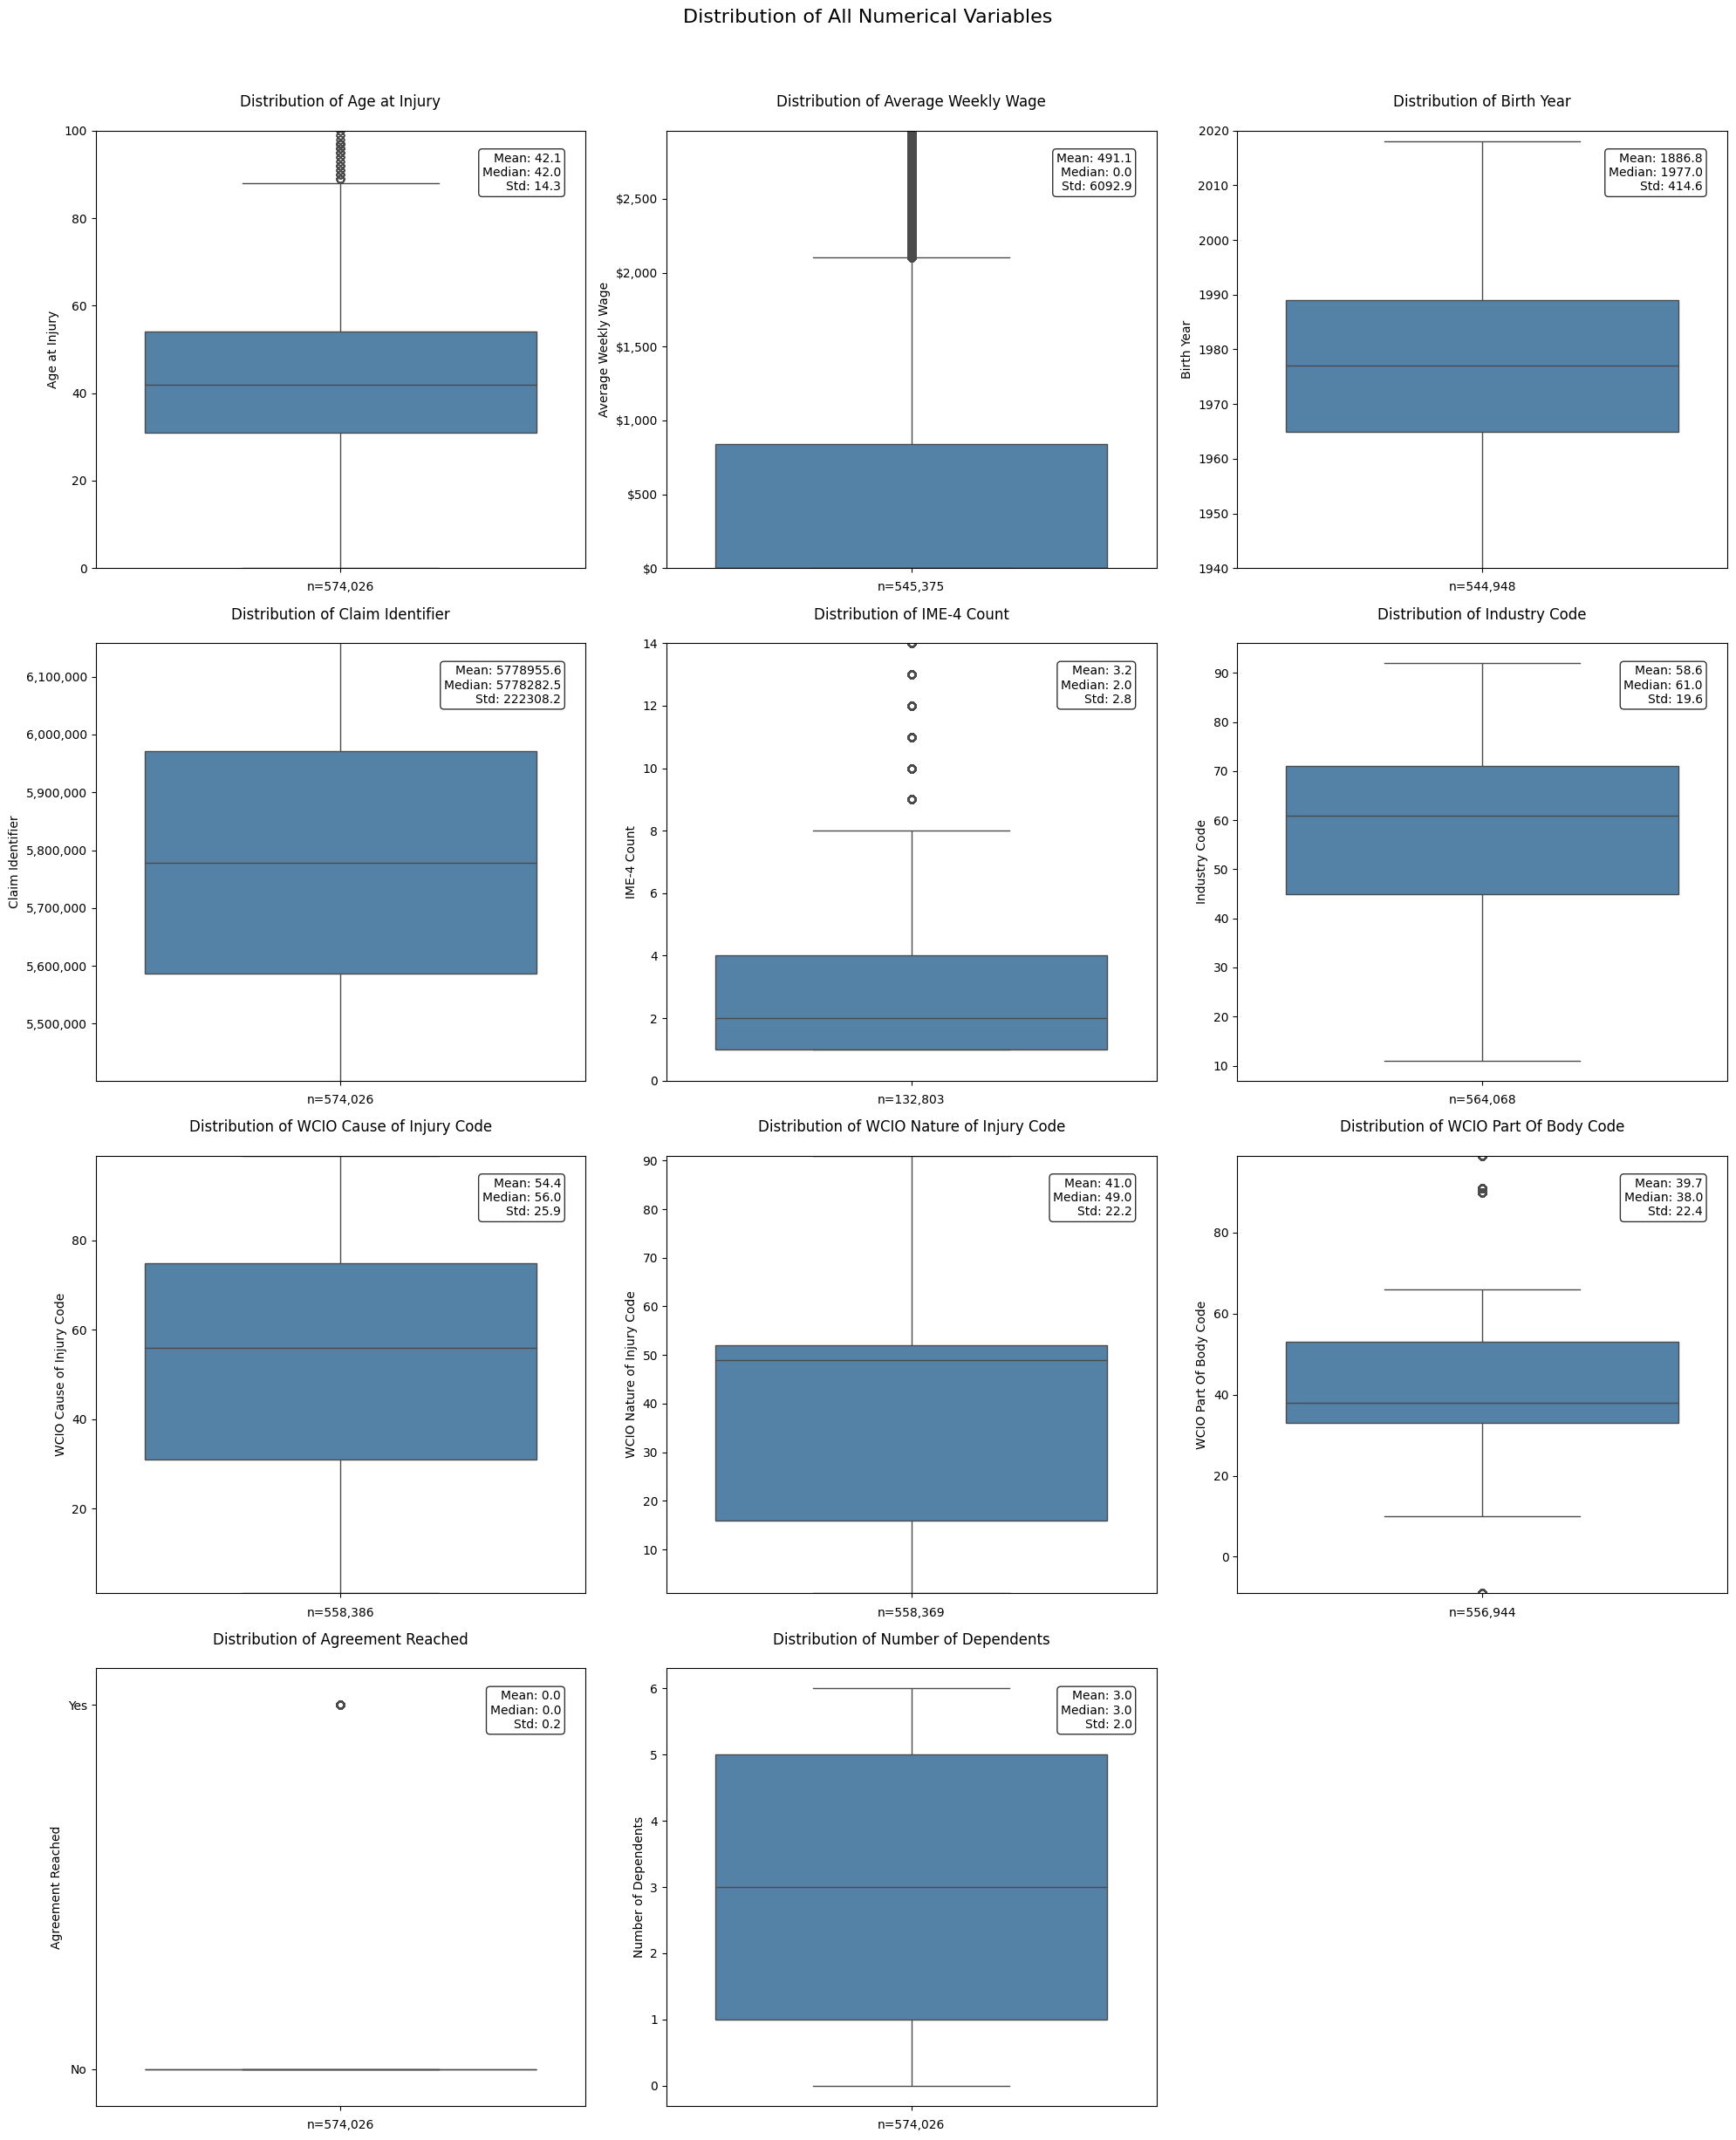


=== Age at Injury ===
count    574026.000000
mean         42.114270
std          14.256432
min           0.000000
25%          31.000000
50%          42.000000
75%          54.000000
max         117.000000
Name: Age at Injury, dtype: float64
Missing values: 0 (0.0%)
--------------------------------------------------

=== Average Weekly Wage ===
count    5.453750e+05
mean     4.910883e+02
std      6.092918e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.410000e+02
max      2.828079e+06
Name: Average Weekly Wage, dtype: float64
Missing values: 28,651 (5.0%)
--------------------------------------------------

=== Birth Year ===
count    544948.000000
mean       1886.767604
std         414.644423
min           0.000000
25%        1965.000000
50%        1977.000000
75%        1989.000000
max        2018.000000
Name: Birth Year, dtype: float64
Missing values: 29,078 (5.1%)
--------------------------------------------------

=== Claim Identifier ===
count    

In [21]:
# Key Data Summary & Recommendations

# Age at Injury (n=293,560):

# Median: 42 years
# Most workers are between ~31-54 years old
# Symmetric distribution around the median
# Outliers up to ~100 years
# Average Weekly Wage (n=278,810):

# Median: $0 (concerning)
# Many $0 values, extreme outliers above $2,500
# Major data issue; recommend separate analysis for non-zero wages
# Birth Year (n=278,726):

# Median: 1976
# IQR: 1964-1988
# Reasonable distribution, but some recent outliers (2020) need investigation
# IME-4 Count (n=71,843):

# Median: 2.0, most have 1-4 IMEs
# Skewed right, with outliers up to 14
# Missing data for 76% of cases
# Industry Code (n=287,988):

# Median: 61.0
# Distribution appears reasonable
# WCIO Codes:

# Cause of Injury: Median 57, wide range
# Nature of Injury: Median 49, expected range
# Part of Body: Median 42, one outlier (-9) needs review
# Agreement Reached (n=293,559):

# Binary (0/1), 6% reach agreement
# Number of Dependents (n=293,559):

# Median: 3.0, range: 0-6
# Key Data Quality Issues & Recommendations:

# Wages: Investigate $0 values, validate outliers, separate analysis for non-zero wages
# Birth Year: Validate recent outliers
# IME-4: Address missing data, investigate high counts
# WCIO Part of Body: Review -9 error codes
# Exclude Claim Identifier from numeric analysis

def create_comprehensive_boxplots(df):
    """
    Create boxplots for all relevant numerical columns with appropriate scaling
    """
    # Define numerical columns to plot
    numerical_cols = [
        'Age at Injury',
        'Average Weekly Wage',
        'Birth Year',
        'Claim Identifier',
        'IME-4 Count',
        'Industry Code',
        'WCIO Cause of Injury Code',
        'WCIO Nature of Injury Code',
        'WCIO Part Of Body Code',
        'Agreement Reached',
        'Number of Dependents'
    ]

    # Calculate number of rows and columns for subplot grid
    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    fig.suptitle('Distribution of All Numerical Variables', fontsize=16, y=1.02)

    # Flatten axes array for easier iteration
    axes_flat = axes.flatten() if hasattr(axes, 'flatten') else [axes]

    for i, col in enumerate(numerical_cols):
        ax = axes_flat[i]

        # Create boxplot
        sns.boxplot(data=df, y=col, ax=ax, color='steelblue')

        # Calculate statistics
        stats = df[col].describe()
        stats_text = f'Mean: {stats["mean"]:.1f}\nMedian: {stats["50%"]:.1f}\nStd: {stats["std"]:.1f}'

        # Add statistics box
        ax.text(0.95, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Customize plot based on variable
        ax.set_title(f'Distribution of {col}', pad=20)

        # Add sample size
        ax.set_xlabel(f'n={df[col].notna().sum():,}')

        # Variable-specific customization
        if col == 'Average Weekly Wage':
            ax.set_ylim(0, df[col].quantile(0.99))  # Show up to 99th percentile
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        elif col == 'Birth Year':
            ax.set_ylim(1940, 2020)
        elif col == 'Age at Injury':
            ax.set_ylim(0, 100)
        elif col == 'IME-4 Count':
            ax.set_ylim(0, df[col].quantile(0.99))
        elif col == 'Claim Identifier':
            ax.set_ylim(df[col].quantile(0.01), df[col].quantile(0.99))
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
        elif col in ['WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']:
            ax.set_ylim(df[col].min(), df[col].max())
        elif col == 'Agreement Reached':
            ax.set_ylim(-0.1, 1.1)
            ax.set_yticks([0, 1])
            ax.set_yticklabels(['No', 'Yes'])

    # Remove empty subplots if any
    for j in range(i + 1, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout()
    return fig

def print_numerical_summaries(df, numerical_cols):
    """
    Print detailed summaries for all numerical columns
    """
    for col in numerical_cols:
        print(f"\n=== {col} ===")
        stats = df[col].describe()
        print(stats)
        print(f"Missing values: {df[col].isna().sum():,} ({df[col].isna().mean():.1%})")
        print("-" * 50)

# Example usage:

# Create the comprehensive boxplots
fig = create_comprehensive_boxplots(train_df)
plt.show()

# Print detailed summaries
numerical_cols = [
    'Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Claim Identifier',
    'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code',
    'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
    'Agreement Reached', 'Number of Dependents'
]
print_numerical_summaries(train_df, numerical_cols)


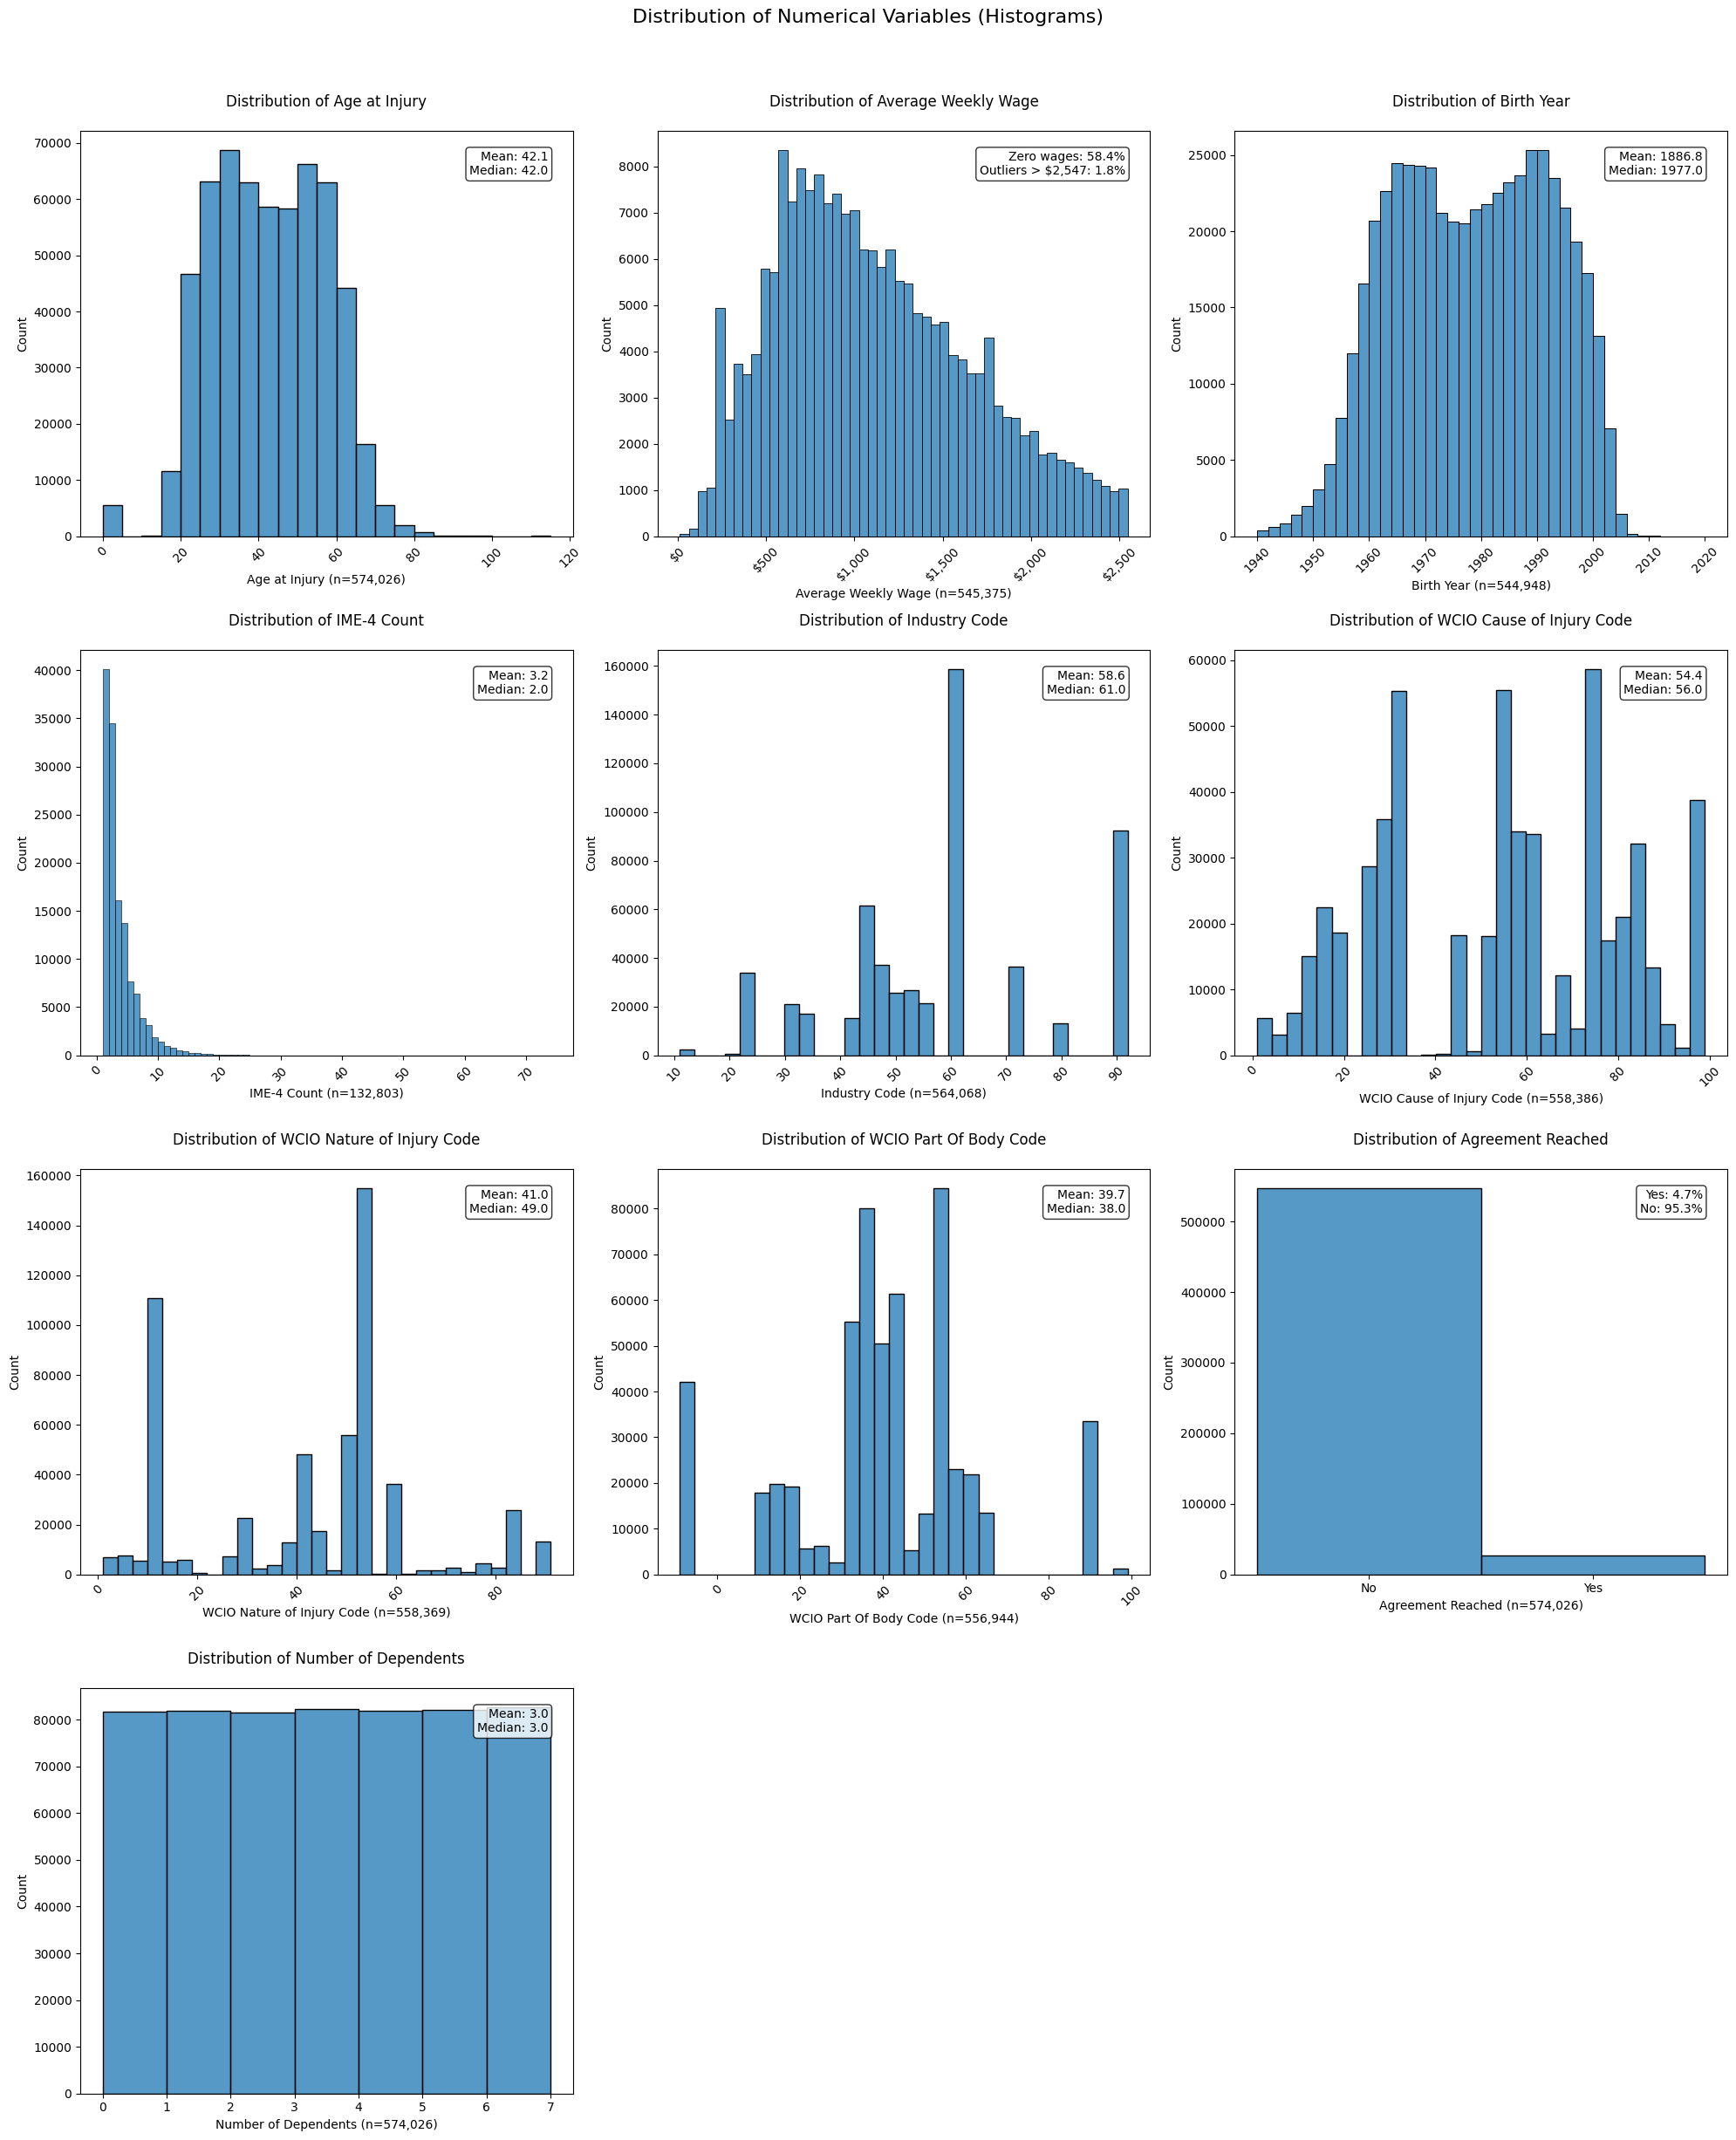


=== Age at Injury ===
count    574026.000000
mean         42.114270
std          14.256432
min           0.000000
25%          31.000000
50%          42.000000
75%          54.000000
max         117.000000
Name: Age at Injury, dtype: float64
Missing values: 0 (0.0%)
--------------------------------------------------

=== Average Weekly Wage ===
count    5.453750e+05
mean     4.910883e+02
std      6.092918e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.410000e+02
max      2.828079e+06
Name: Average Weekly Wage, dtype: float64
Missing values: 28,651 (5.0%)
Zero values: 335,450 (58.4%)
--------------------------------------------------

=== Birth Year ===
count    544948.000000
mean       1886.767604
std         414.644423
min           0.000000
25%        1965.000000
50%        1977.000000
75%        1989.000000
max        2018.000000
Name: Birth Year, dtype: float64
Missing values: 29,078 (5.1%)
--------------------------------------------------

=== C

In [22]:
# Age at Injury (n=293,560): Bell-shaped, slightly right-skewed. Peak around 35-45 years. Mean/Median both around 42 years. Few cases under 20 or over 80. Represents typical working-age population.

# Average Weekly Wage (n=278,810): Median: $0 (concerning) Many $0 values, extreme outliers above $2,500 Major data issue; recommend separate analysis for non-zero wages

# Birth Year (n=278,726): Bimodal. Peaks around 1965 and 1985. Mean: 1877.0, Median: 1976.0. Spans roughly 1950-2000, reflecting two workforce generations.

# IME-4 Count (n=71,843): Extremely right-skewed. Most cases have 1-2 IMEs. Rapidly decreasing frequency for higher counts. Very few cases with >10 IMEs. Classic Poisson-like distribution.

# Industry Code (n=287,988): Multimodal. Major peaks at codes 45, 61, and 80. Suggests concentration in specific industries. Not evenly distributed across all codes. Several distinct clusters of industry types.

# WCIO Cause of Injury Code (n=284,925): Multiple distinct peaks. Major spikes at codes 20, 40, and 60. Suggests common injury causes are well-categorized. Fairly even distribution between major categories.

# WCIO Nature of Injury Code (n=284,921): Several distinct peaks. Largest spike around code 50. Secondary peaks at 25 and 40. Very specific injury types dominate.

# WCIO Part of Body Code (n=284,099): Multiple distinct peaks. Major concentrations around codes 30, 40, and 50. Suggests certain body parts are more commonly injured. Some codes rarely used.

# Agreement Reached (n=293,559): Binary distribution. Heavily imbalanced. Only 5.91% "Yes". 94.09% "No". Clear minority of cases reach agreement.

# Number of Dependents (n=293,559): Discrete distribution from 0-6. Fairly uniform distribution. Slightly higher counts for 2-4 dependents. Mean and median both 3.0. Full range utilized.

# Key Insights:

# Workforce Demographics: Two distinct age groups (reflected in birth years). Working-age population well represented.
# Claims Processing: Very low agreement rate (5.91%). Most cases have few IMEs. Systematic coding of injury types/causes.
# Data Quality Concerns: High proportion of zero wages needs investigation. Some extreme wage outliers. Industry codes show clear clustering.
# Injury Patterns: Clear patterns in body parts affected. Specific injury types dominate. Systematic cause coding.
# Recommendations:

# Investigate zero wages - potential data quality issue.
# Consider separate analysis for different age cohorts.
# Examine relationship between industry codes and injury types.
# Investigate factors contributing to low agreement rate.
# Consider standardizing injury coding distributions.

def create_histograms(df):
    """
    Create histograms for all numerical variables with appropriate binning and scaling
    """
    numerical_cols = [
        'Age at Injury',  # 0-117
        'Average Weekly Wage',  # 0-2,659,398
        'Birth Year',  # 0-2018
        'IME-4 Count',  # 1-48
        'Industry Code',  # 11-92
        'WCIO Cause of Injury Code',  # 1-99
        'WCIO Nature of Injury Code',  # 1-91
        'WCIO Part Of Body Code',  # -9-99
        'Agreement Reached',  # 0-1
        'Number of Dependents'  # 0-6
    ]

    # Calculate number of rows and columns for subplot grid
    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    fig.suptitle('Distribution of Numerical Variables (Histograms)', fontsize=16, y=1.02)

    # Flatten axes array for easier iteration
    axes_flat = axes.flatten() if hasattr(axes, 'flatten') else [axes]

    for i, col in enumerate(numerical_cols):
        ax = axes_flat[i]

        # Custom handling for each variable type
        if col == 'Average Weekly Wage':
            # Plot non-zero wages up to 95th percentile
            non_zero_wages = df[df[col] > 0][col]
            max_wage = non_zero_wages.quantile(0.95)
            sns.histplot(data=non_zero_wages[non_zero_wages <= max_wage],
                        bins=50, ax=ax)
            ax.set_xlabel(f'${col} (up to 95th percentile)')
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

            # Add text about zeros and outliers
            zero_pct = (df[col] == 0).mean() * 100
            outlier_pct = (df[col] > max_wage).mean() * 100
            stats_text = f'Zero wages: {zero_pct:.1f}%\nOutliers > ${max_wage:,.0f}: {outlier_pct:.1f}%'

        elif col == 'Age at Injury':
            sns.histplot(data=df[col], bins=np.arange(0, 120, 5), ax=ax)
            stats_text = f'Mean: {df[col].mean():.1f}\nMedian: {df[col].median():.1f}'

        elif col == 'Birth Year':
            sns.histplot(data=df[col], bins=np.arange(1940, 2021, 2), ax=ax)
            stats_text = f'Mean: {df[col].mean():.1f}\nMedian: {df[col].median():.1f}'

        elif col == 'IME-4 Count':
            sns.histplot(data=df[col], bins=range(int(df[col].min()), int(df[col].max()) + 2), ax=ax)
            stats_text = f'Mean: {df[col].mean():.1f}\nMedian: {df[col].median():.1f}'

        elif col == 'Number of Dependents':
            sns.histplot(data=df[col], bins=range(int(df[col].min()), int(df[col].max()) + 2), ax=ax)
            stats_text = f'Mean: {df[col].mean():.1f}\nMedian: {df[col].median():.1f}'

        elif col == 'Agreement Reached':
            sns.histplot(data=df[col], bins=[-0.5, 0.5, 1.5], ax=ax)
            ax.set_xticks([0, 1])
            ax.set_xticklabels(['No', 'Yes'])
            stats_text = f'Yes: {(df[col]==1).mean():.1%}\nNo: {(df[col]==0).mean():.1%}'

        else:  # For other numerical codes
            sns.histplot(data=df[col], bins=30, ax=ax)
            stats_text = f'Mean: {df[col].mean():.1f}\nMedian: {df[col].median():.1f}'

        # Add statistics
        ax.text(0.95, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Add title and sample size
        ax.set_title(f'Distribution of {col}', pad=20)
        n_samples = df[col].notna().sum()
        ax.set_xlabel(f'{col} (n={n_samples:,})')

        # Rotate x-axis labels if needed
        if not col in ['Agreement Reached', 'Number of Dependents']:
            ax.tick_params(axis='x', rotation=45)

    # Remove empty subplots if any
    for j in range(i + 1, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout()
    return fig

# Print summary statistics
def print_distribution_stats(df):
    """Print detailed distribution statistics for each numerical variable"""
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        print(f"\n=== {col} ===")
        stats = df[col].describe()
        print(stats)
        print(f"Missing values: {df[col].isna().sum():,} ({df[col].isna().mean():.1%})")
        if col == 'Average Weekly Wage':
            print(f"Zero values: {(df[col] == 0).sum():,} ({(df[col] == 0).mean():.1%})")
        print("-" * 50)

# Usage:

fig = create_histograms(train_df)
plt.show()
print_distribution_stats(train_df)


# Chiel, i want to do EDA for categorical values here later

### Converting categorical variables to numerical
 We have to mind if they are nominal or ordinal

In [23]:
# New to change zip to str to use freq

features_to_encode_freq = [
    "Alternative Dispute Resolution",  "Carrier Name",
    "County of Injury", "District Name", "Gender", "Medical Fee Region", "Zip Code"]

features_to_encode_binary = ["Attorney/Representative", "COVID-19 Indicator", "Carrier Type", "Claim Injury Type"]

#features_to_encode_ordinal = ["Carrier Type", "Claim Injury Type"]

features_to_metadata = [ "Claim Identifier",
    "OIICS Nature of Injury Description",
    "Industry Code Description", "WCIO Cause of Injury Description", "WCIO Cause of Injury Description",
    "WCIO Nature of Injury Description", "WCIO Part Of Body Description"
]

encoders_dict = {}

multiencoder(train_df, features_to_encode_freq, "frequency", encoders_dict)
multiencoder(train_df, features_to_encode_binary, "binary", encoders_dict)

#### Feature engineering and date to days/years

In [24]:
features_to_dummy = ['First Hearing Date', 'C-2 Date', 'C-3 Date']
gen_dummy(train_df,features_to_dummy)

In [25]:
features_to_days = ["Accident Date", "Assembly Date", "First Hearing Date", "Birth Year"]
date_to_number(train_df, features_to_days)

In [26]:
features_to_drop = features_to_metadata + features_to_days + ["C-2 Date", "C-3 Date"]

for feature in features_to_drop:
    try:
        train_df = train_df.drop(feature, axis = 1)
    except:
        print(f"{feature} no longer in train_df")

WCIO Cause of Injury Description no longer in train_df


In [27]:
train_df.to_csv("./data/train_data_after_EDA.csv")

In [29]:
print("Classification Report for Training Data:")
print(classification_report(y_train, dt_train_pred))

# Generate the classification report for validation data
print("Classification Report for Validation Data:")
print(classification_report(y_val, dt_val_pred))

Classification Report for Training Data:


NameError: name 'y_train' is not defined